## Optimising latent space dynamics for computational efficiency

Chemical kinetics

\begin{equation}
\frac{\text{d}z_{i}}{\text{d}t} \ = \ A_{ij} z_{j}+B_{ijk}z_jz_k
\end{equation}

In [1]:
import torch
import torchode          as to
import numpy             as np
import matplotlib.pyplot as plt

from tqdm   import tqdm
from time   import time


In [4]:
def g(t, z, args):
    A, B = args
    return torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z)


def make_args(n_latent):
    A  = torch.randn(n_latent, n_latent)
    B  = torch.randn(n_latent, n_latent, n_latent)

    return A,B

def make_setup(z0, n_batch, n_latent):

    # Initial conditions
    t0 = 0.0

    # End time and time step
    t1 = 1.e0
    dt = 1.0e-2
    t_eval = torch.arange(t0, t1, step=dt)

    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch        = torch.rand(n_batch,n_latent) *2-1

    return t_eval_batch, z0_batch


def solver(z0, args, atol, rtol, n_batch, n_latent,DEVICE):
    t_eval,z_0 = make_setup(z0, n_batch, n_latent)

    odeterm = to.ODETerm(g, with_args=True)
    step_method          = to.Dopri5(term=odeterm)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=odeterm)
    adjoint              = to.AutoDiffAdjoint(step_method, step_size_controller).to(DEVICE) # type: ignore

    jit_solver = torch.compile(adjoint)

    problem = to.InitialValueProblem(
        y0     = z_0,  ## "view" is om met de batches om te gaan
        t_eval = t_eval,
    )

    solution = jit_solver.solve(problem, args=args)

    return t_eval,solution.ys.data


# Setup solver
def solve(z0, args, f, atol, rtol, n_batch,n_latent):
    start = time()

    t_eval,t_eval_batch, z0_batch = make_setup(z0, n_batch,n_latent)

    
    term                 = to.ODETerm(f, with_args=True)
    step_method          = to.Dopri5(term=term)
    step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
    # step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
    solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

    # Compile solver\
    jit_solver = torch.compile(solver)

    t_eval_batch    = torch.empty(n_batch, t_eval.shape[0])
    z0_batch        = torch.empty(n_batch,     z0.shape[0])

    t_eval_batch[:] = t_eval
    z0_batch    [:] = z0


    # Setup initial value problem\n",
    problem = to.InitialValueProblem(y0=z0_batch, t_eval=t_eval_batch)

    # Run solver
    wct =- time()
    solution = jit_solver.solve(problem, args=args)
    wct += time()

    print("elapsed time:", wct)
    print("success?     ", torch.all(solution.status == 0).item())

    return solution.ys[0].data

In [39]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

n_latent = 10
n_batch  = 2000

atol = 1.0e-5
rtol = 1.0e-2

args = make_args(n_latent)

z0 = torch.rand(n_latent)*2-1

t,sol = solver(z0, args, atol, rtol, n_batch, n_latent, DEVICE)


In [56]:
w = np.where(np.logical_or(np.abs(sol) > 10,np.isnan(sol)))

w

(array([   0,    0,    1, ..., 1999, 1999, 1999]),
 array([29, 29, 16, ..., 23, 23, 23]),
 array([5, 9, 2, ..., 5, 6, 9]))

In [57]:
idx = [0]
count = 0
absent = list()
for i in range(1,len(w[0])):
    if w[0][i] != w[0][i-1]:
        idx.append(i)
        if w[0][i] != w[0][i-1]+1:
            k = w[0][i]
            diff = (w[0][i] - w[0][i-1]-1) 
            while diff != 0:
                absent.append(k-1)  
                k = k-1
                diff -=1
            count += 1
            # print('nope', i, w[0][i], w[0]i-1], diff)
print(count, absent)
print(len(idx),idx)
print(sol.shape)

0 []
2000 [0, 2, 16, 23, 39, 58, 66, 71, 77, 90, 99, 106, 124, 132, 137, 147, 152, 160, 167, 177, 187, 200, 216, 224, 234, 246, 249, 260, 269, 274, 285, 293, 305, 313, 326, 329, 341, 355, 370, 378, 379, 394, 406, 418, 419, 427, 444, 457, 471, 478, 489, 491, 492, 506, 515, 524, 544, 552, 562, 570, 580, 599, 607, 619, 627, 646, 659, 666, 671, 680, 687, 691, 696, 706, 726, 735, 742, 751, 763, 766, 781, 789, 796, 808, 817, 823, 828, 834, 837, 848, 860, 874, 885, 898, 905, 908, 922, 936, 943, 954, 961, 982, 989, 1010, 1021, 1025, 1043, 1045, 1056, 1062, 1076, 1087, 1090, 1095, 1107, 1126, 1138, 1142, 1153, 1164, 1172, 1186, 1198, 1206, 1217, 1221, 1234, 1246, 1250, 1266, 1276, 1289, 1299, 1305, 1311, 1313, 1323, 1331, 1350, 1353, 1364, 1370, 1385, 1398, 1408, 1415, 1426, 1434, 1449, 1455, 1466, 1475, 1487, 1503, 1509, 1520, 1535, 1546, 1553, 1564, 1570, 1583, 1595, 1598, 1603, 1611, 1622, 1634, 1641, 1655, 1663, 1670, 1683, 1694, 1707, 1723, 1736, 1746, 1758, 1764, 1771, 1788, 1796, 1809, 1

In [55]:
sol[367]

tensor([[ 2.6219e-01, -6.3160e-01, -1.4040e-01, -8.2710e-01, -5.9913e-01,
         -2.7945e-01, -1.4108e-01,  6.0557e-02, -7.1260e-01,  3.5718e-01],
        [ 2.8915e-01, -6.0912e-01, -1.5696e-01, -8.2751e-01, -6.2492e-01,
         -2.9766e-01, -8.9010e-02,  8.9177e-02, -6.7926e-01,  3.4592e-01],
        [ 3.1753e-01, -5.8833e-01, -1.7509e-01, -8.3170e-01, -6.4870e-01,
         -3.1715e-01, -3.8375e-02,  1.1876e-01, -6.4686e-01,  3.3330e-01],
        [ 3.4755e-01, -5.6914e-01, -1.9481e-01, -8.3984e-01, -6.7057e-01,
         -3.3809e-01,  1.1166e-02,  1.4915e-01, -6.1519e-01,  3.1876e-01],
        [ 3.7949e-01, -5.5149e-01, -2.1614e-01, -8.5217e-01, -6.9066e-01,
         -3.6067e-01,  5.9947e-02,  1.8024e-01, -5.8405e-01,  3.0176e-01],
        [ 4.1366e-01, -5.3528e-01, -2.3915e-01, -8.6898e-01, -7.0907e-01,
         -3.8508e-01,  1.0829e-01,  2.1192e-01, -5.5328e-01,  2.8171e-01],
        [ 4.5049e-01, -5.2038e-01, -2.6394e-01, -8.9072e-01, -7.2589e-01,
         -4.1152e-01,  1.5648e-0

100%|██████████| 2000/2000 [00:14<00:00, 135.06it/s]
0it [00:00, ?it/s]


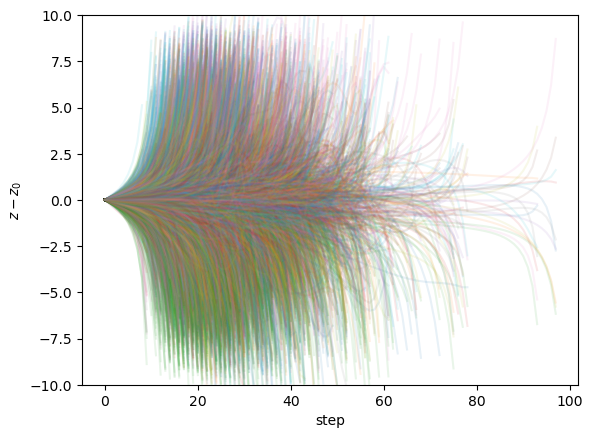

In [60]:
# print(t.shape,sol.shape)

# for i in tqdm(range(sol.shape[0])):

a = 0.1


for i in tqdm(range(len(idx))):
    j = w[1][idx[i]]
    plt.plot(sol[i][:j]-sol[i][0], '-', alpha = a)
for i in tqdm(range(len(absent))):
    plt.plot(sol[i]-sol[i][0], '-', alpha = a)

plt.ylabel('$z-z_0$')
plt.xlabel('step')

ylim = 10
plt.ylim([-ylim,ylim])
# plt.xlim([0,10])

# plt.yscale('log')

plt.show()

100%|██████████| 2000/2000 [00:25<00:00, 79.08it/s]


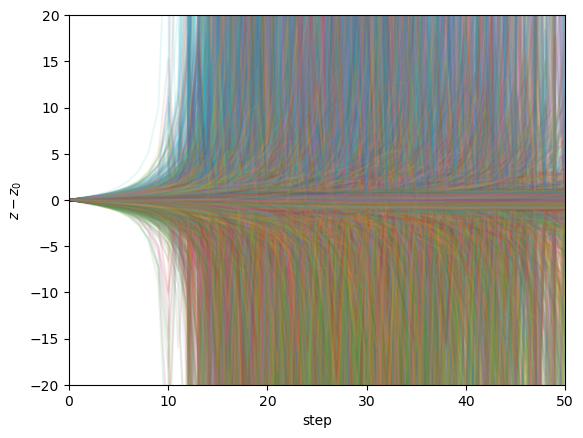

In [48]:
# print(t.shape,sol.shape)



a = 0.1
for i in tqdm(range(sol.shape[0])):
    plt.plot(sol[i]-sol[i][0], '-', alpha = a)


plt.ylabel('$z-z_0$')
plt.xlabel('step')

plt.ylim([-20,20])
plt.xlim([0,50])

# plt.yscale('log')

plt.show()

torch.Size([10000, 100]) torch.Size([10000, 100, 10])


100%|██████████| 10000/10000 [01:57<00:00, 85.45it/s]


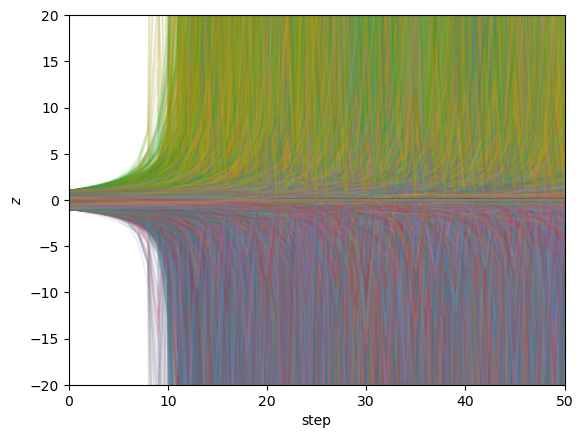

In [12]:
print(t.shape,sol.shape)

for i in tqdm(range(sol.shape[0])):
    plt.plot(sol[i], '-', alpha = 0.1)

plt.ylabel('$z$')
plt.xlabel('step')

plt.ylim([-20,20])
plt.xlim([0,50])

# plt.yscale('log')

plt.show()

### with NNs

In [5]:
class LatentODE(torch.nn.Module):
    
    def __init__(self, n_latent):
        
        super().__init__()
        
        self.n_latent = n_latent

        self.lin_1 = torch.nn.Linear(n_latent, n_latent)
        self.lin_2 = torch.nn.Linear(n_latent, n_latent)
        self.lin_3 = torch.nn.Linear(n_latent, n_latent)
        
        self.relu = torch.nn.LeakyReLU(0.2)
        self.sigm = torch.nn.Sigmoid()
        
    def forward(self, t, z):
        
        result = self.relu(self.lin_1(z))
        result = self.relu(self.lin_2(result))
        result = self.sigm(self.lin_3(result))
        
        return result
    
g = LatentODE(n_latent)

elapsed time: 0.017088890075683594
success?      True


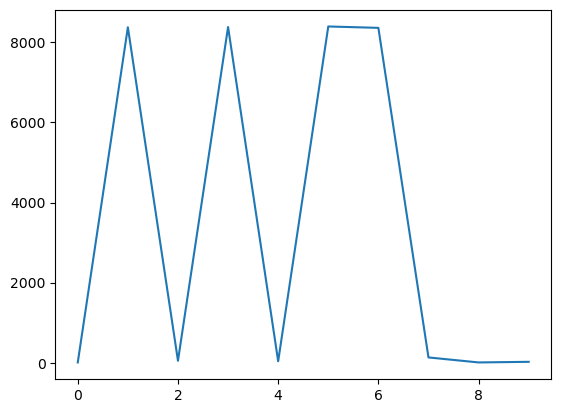

In [ ]:
# Setup solver
term                 = to.ODETerm(g.forward)#, with_args=True)
step_method          = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=atol, rtol=rtol, term=term)
# step_size_controller = to.PIDController(atol=atol, rtol=rtol, pcoeff=0.2, icoeff=0.5, dcoeff=0.0, term=term)
solver               = to.AutoDiffAdjoint(step_method, step_size_controller)

# Compile solver\n",
jit_solver = torch.compile(solver)


# Setup initial value problem\n",
problem = to.InitialValueProblem(y0=z0_batch, t_eval=t_eval_batch)

# Run solver\n",
wct =- time()
solution = jit_solver.solve(problem, args=args)
# solution =     solver.solve(problem)#, args=args)
wct += time()
print("elapsed time:", wct)
print("success?     ", torch.all(solution.status == 0).item())

yt_torch = solution.ys[0][-1].detach().numpy()

plt.plot(yt_torch)